# Local features

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

## Harris detector

In the first example we use Harris keypoint detector to find corner points from a stereo image pair.

In [3]:
img1 = cv2.imread('images/left.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('images/right.jpg')
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

Here are the input images.

(-0.5, 611.5, 458.5, -0.5)

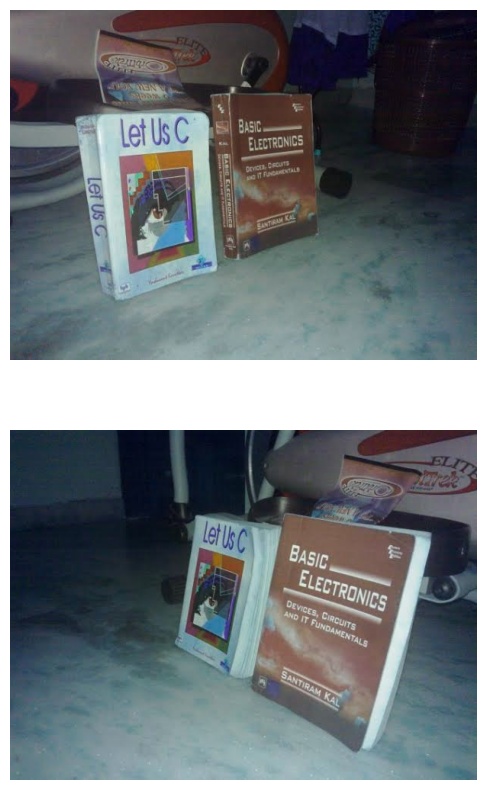

In [4]:
plt.figure(figsize=(7, 10))
plt.subplot(211)
plt.imshow(img1)
plt.axis('off')
plt.subplot(212)
plt.imshow(img2)
plt.axis('off')

In [5]:
har1 = cv2.cornerHarris(gray1,2,3,0.04)
har2 = cv2.cornerHarris(gray2,2,3,0.04)

These are the corresponding Harris corners that are thresholded from the response image by accepting only those points where the response is at least 1% of the maximum response.

(-0.5, 611.5, 458.5, -0.5)

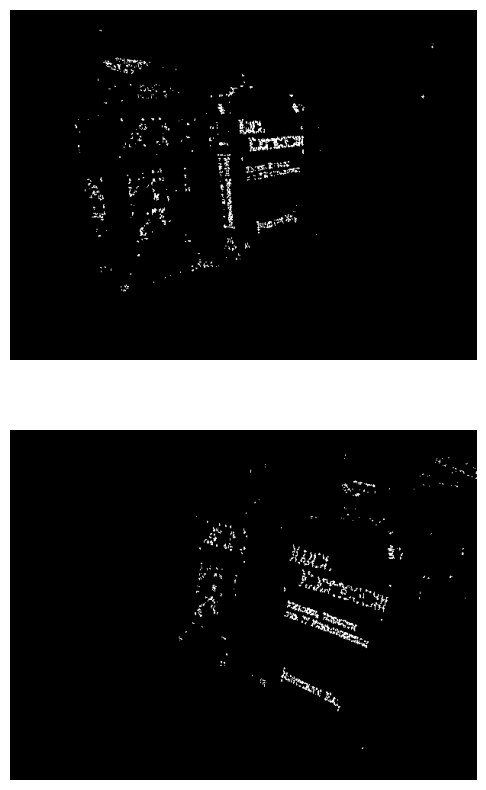

In [6]:
plt.figure(figsize=(7, 10))
plt.subplot(211)
plt.imshow(har1>0.01*har1.max(), cmap='gray')
plt.axis('off')
plt.subplot(212)
plt.imshow(har2>0.01*har2.max(), cmap='gray')
plt.axis('off')

As we can see the points tend to form clusters. To reduce the amount of points and selecting only isolated corners points we implement a simple function for non-maximum suppression.

In [7]:
def nms(resp):
    out = resp.copy()
    mi = resp.min()
    dil = cv2.dilate(out, None)
    out[out < dil] = mi
    return(out)

In [8]:
nm1 = nms(har1)
nm2 = nms(har2)

Then we dilate the remaining points to make them to appear larger.

In [9]:
nm1 = cv2.dilate(nm1, None, iterations = 2)
nm2 = cv2.dilate(nm2, None, iterations = 2)

In [10]:
out1 = cv2.cvtColor(gray1, cv2.COLOR_GRAY2RGB)
out2 = cv2.cvtColor(gray2, cv2.COLOR_GRAY2RGB)
out1[nm1>0.01*nm1.max()] = [255, 0, 0]
out2[nm2>0.01*nm2.max()] = [255, 0, 0]

Here are the remaining corners. We can observe that some of the corners appear in both images, and it is in principle possible to establish point correspondence using these corners.

(-0.5, 611.5, 458.5, -0.5)

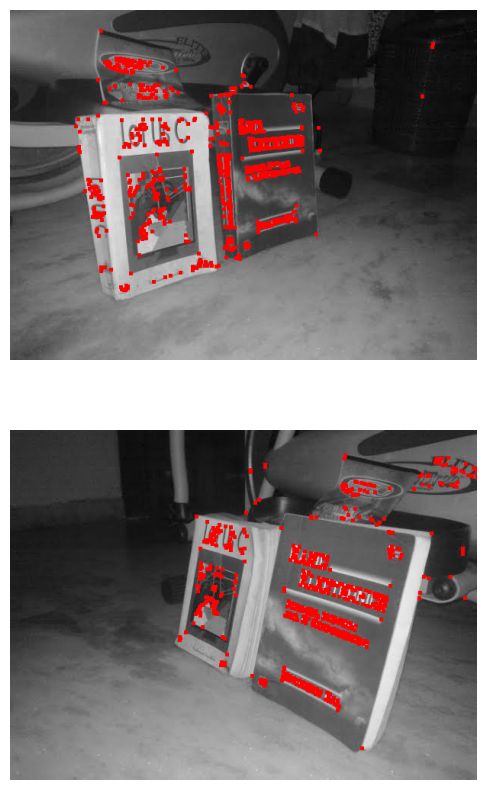

In [11]:
plt.figure(figsize=(7, 10))
plt.subplot(211)
plt.imshow(out1)
plt.axis('off')
plt.subplot(212)
plt.imshow(out2)
plt.axis('off')

## SIFT keypoints

The problem with the Harris corners is that the detector is not scale or rotation invariant. Therefore, it does not perform well if there are significant viewpoint changes between the images. Next we try something more efficient. SIFT features are designed to be both scale and rotation invariant. There is a separate feature detector to find the keypoints from the image and a descriptor for matching the keypoints. First, we extract the keypoints from the same stereo pair shown above.

In [12]:
sift = cv2.SIFT_create()

In [13]:
kp1 = sift.detect(gray1,None)
kp2 = sift.detect(gray2,None)

The keypoints are visualized below. The radius of the circle around the keypoint represents the scale, and the arrow shows the principal orientation of the keypoint.

In [14]:
kpout1=cv2.drawKeypoints(gray1,kp1,None,None,cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kpout2=cv2.drawKeypoints(gray2,kp2,None,None,cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

(-0.5, 611.5, 458.5, -0.5)

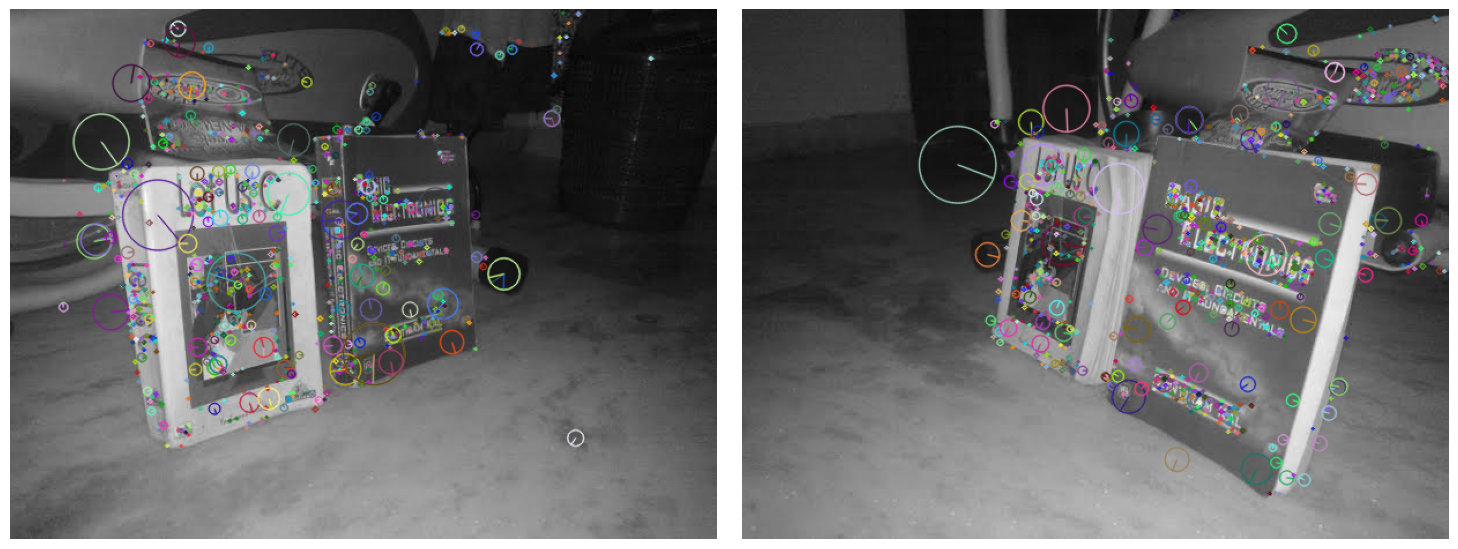

In [15]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.tight_layout()
plt.imshow(kpout1)
plt.axis('off')
plt.subplot(122)
plt.imshow(kpout2)
plt.axis('off')

We can see that there are many keypoints that have been detected from both images.

## MSER regions

Another approach for finding correspondences between images is to segment the image into regions that exist in both images. Segmentation in general may produce regions that are not stable enough to tolerate noise, geometric and radiometric transformations between images. Maximally stable extremal regions (MSER) is a method that tries to identify those regions that are sufficiently stable. So, let's try MSER to the same image pair.

In [16]:
mser = cv2.MSER_create()

In [17]:
regions1 = mser.detectRegions(gray1)
regions2 = mser.detectRegions(gray2)

The following function visualizes the MSER regions by assigning a random color to each region detected. The result is shown below.

In [18]:
def mser_mask(img, regions):
    mask = np.zeros(img.shape, dtype = np.uint8)
    for i in range(len(regions[0])):
        color = np.random.rand(1,1,3)*255
        mask[regions[0][i][:,1],regions[0][i][:,0],:] = color
    return mask

In [19]:
mask1 = mser_mask(img1, regions1)
mask2 = mser_mask(img2, regions2)

(-0.5, 611.5, 458.5, -0.5)

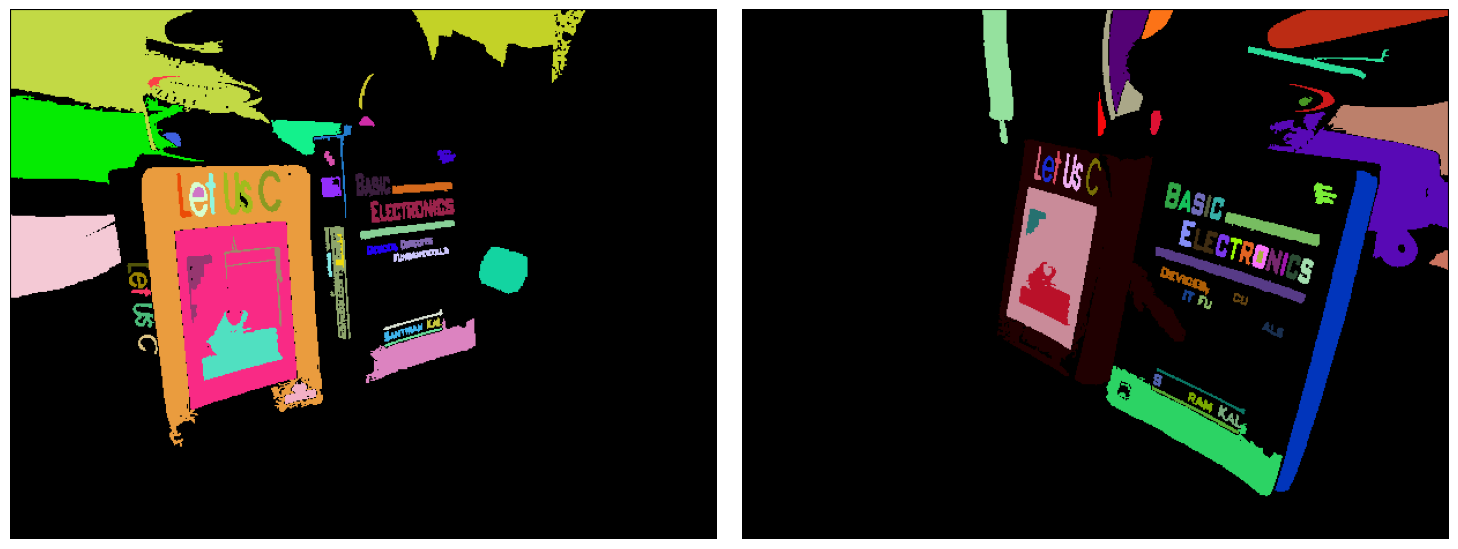

In [20]:
plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.tight_layout()
plt.imshow(mask1)
plt.axis('off')
plt.subplot(122)
plt.imshow(mask2)
plt.axis('off')

One obvious problem is that adjacent regions may be merged together depending on the scale.

## Feature desciption

After detecting the local features (keyponts, corners, regions) we need some descriptors to find out what are the corresponding features between the images. SIFT descriptor is a popular choice because the descriptor is invariant to geometric transformations (translation, scaling and rotation) and radiometric transformations (affine transformations of the pixel intensity values). We use the previously extracted keypoints to compute the local descriptors for the image patches surrounding them. Two sample patches and corresponding descriptors are shown below. Notice that the descriptor is a histogram of 128 bins.

In [21]:
kpp1, desc1 = sift.compute(gray1, kp1)
kpp2, desc2 = sift.compute(gray2, kp2)

In [22]:
pt1=np.uint16(kpp1[11].pt)
pt2=np.uint16(kpp1[14].pt)
patch1 = gray1[pt1[1]-32:pt1[1]+32,pt1[0]-32:pt1[0]+32]
patch2 = gray1[pt2[1]-32:pt2[1]+32,pt2[0]-32:pt2[0]+32]

<BarContainer object of 128 artists>

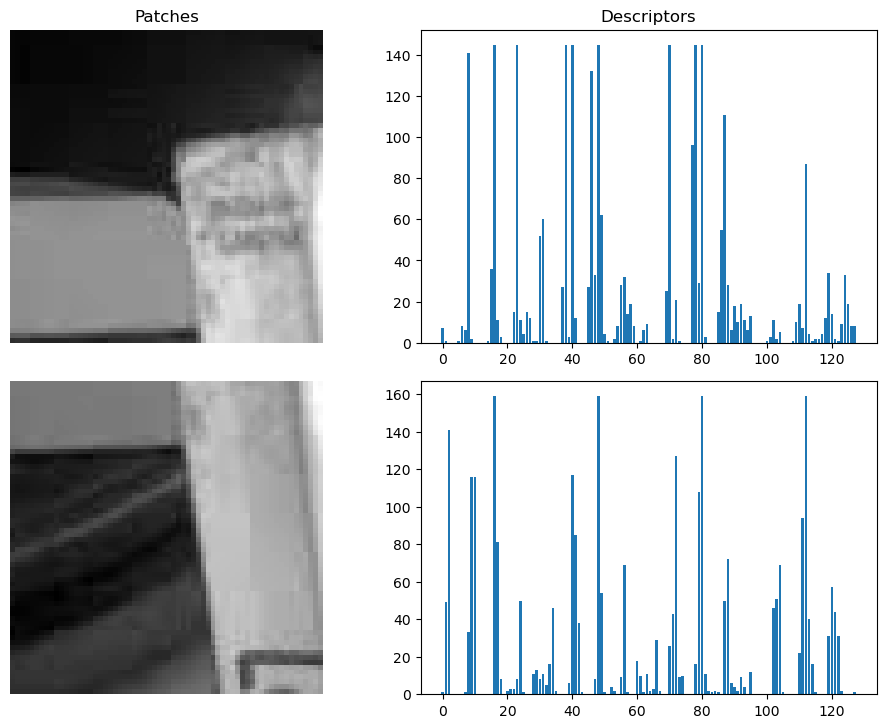

In [23]:
plt.figure(figsize=(10,7))
plt.subplot(221)
plt.tight_layout()
plt.title('Patches')
plt.imshow(patch1, cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.title('Descriptors')
plt.bar(np.arange(128),desc1[11])
plt.subplot(223)
plt.imshow(patch2, cmap='gray')
plt.axis('off')
plt.subplot(224)
plt.bar(np.arange(128),desc1[14])

## Feature matching

Next, we try to match the local features based on their descriptors. For each keypoint in the first image we find two best matching keypoints from the second image. We use the ratio distance of 0.5 to determine the good matches. From those, the 10 best matches with the smallest $L_2$ distance are illustrated below.

In [24]:
bf = cv2.BFMatcher()

In [25]:
matches = bf.knnMatch(desc1,desc2, k=2)

In [26]:
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

In [27]:
good = sorted(good, key = lambda x:x[0].distance)

In [28]:
img = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good[:10],None,flags=2)

(-0.5, 1223.5, 458.5, -0.5)

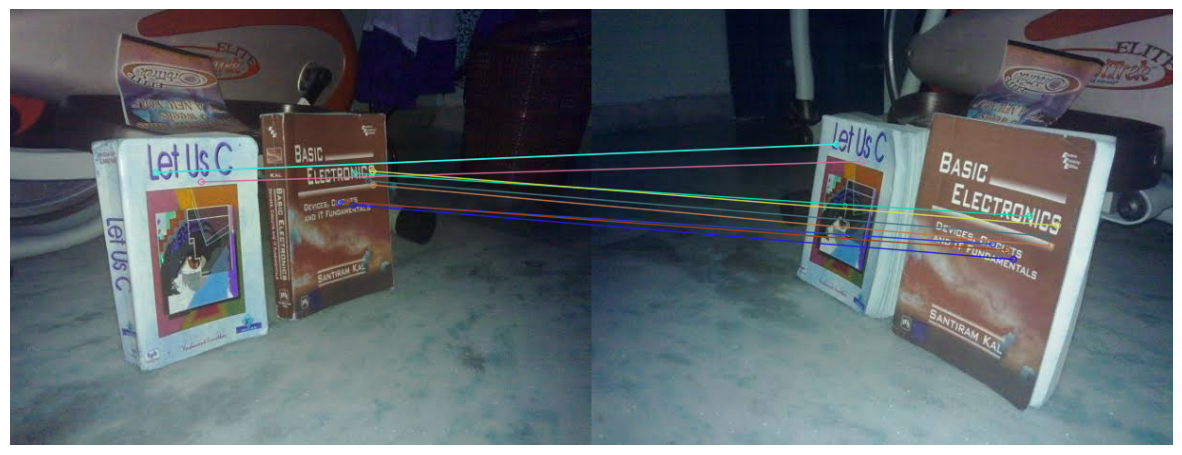

In [29]:
plt.figure(figsize=(15,8))
plt.imshow(img)
plt.axis('off')